In [54]:
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
df = pd.read_csv("data/us_sector_etf_9_ohlc.csv", header=[0, 1], index_col=0)
df.index = pd.to_datetime(df.index)

START_DATE = df.index[0]
COST_BPS = 10
TOP_K = 3

adj_close = df['Adj Close'].copy()
volume = df['Volume'].copy()
adj_close = adj_close.loc[adj_close.index >= START_DATE]
volume = volume.loc[volume.index >= START_DATE]
adj_close = adj_close.astype(float).ffill()
volume = volume.astype(float)

In [56]:
def monthly_from_daily(adj_close_daily: pd.DataFrame, volume_daily: pd.DataFrame):
    monthly_price = adj_close_daily.resample('ME').last()
    monthly_ret = monthly_price.pct_change()
    monthly_vol_sum = volume_daily.resample('ME').sum(min_count=1)
    monthly_mom = monthly_price.shift(2) / monthly_price.shift(12) - 1
    return monthly_price, monthly_ret, monthly_vol_sum, monthly_mom

def monthly_excluding_last_3_days(adj_close_daily: pd.DataFrame, volume_daily: pd.DataFrame):
    idx = adj_close_daily.index
    month_key = idx.to_period('M')
    rank_from_end = idx.to_series(index=idx).groupby(month_key).cumcount(ascending=False) + 1
    keep_mask = rank_from_end > 3
    # Keep only rows excluding each month's last 3 trading days.
    adj_keep = adj_close_daily.loc[keep_mask.values].copy()
    vol_keep = volume_daily.loc[keep_mask.values].copy()
    month_key_keep = adj_keep.index.to_period('M')
    price_eom = adj_keep.groupby(month_key_keep).last()
    vol_eom = vol_keep.groupby(month_key_keep).sum(min_count=1)
    price_eom.index = price_eom.index.to_timestamp(how='end').normalize()
    vol_eom.index = vol_eom.index.to_timestamp(how='end').normalize()
    ret_eom = price_eom.pct_change()
    mom_eom = price_eom.shift(2) / price_eom.shift(12) - 1
    return price_eom, ret_eom, vol_eom, mom_eom

In [57]:
monthly_price, monthly_ret, monthly_vol, momentum_proxy = monthly_from_daily(adj_close, volume)
monthly_price_eom, monthly_ret_eom, monthly_vol_eom, momentum_proxy_eom = monthly_excluding_last_3_days(adj_close, volume)
print('monthly rows:', len(monthly_ret))
print('monthly rows (EOM excl.):', len(monthly_ret_eom))

monthly rows: 182
monthly rows (EOM excl.): 182


In [58]:
@dataclass
class StrategyResult:
    name: str
    ret_gross: pd.Series
    turnover: pd.Series
    ret_net: pd.Series
    weights: pd.DataFrame

In [59]:
def build_eqw_strategy(
    monthly_ret: pd.DataFrame,
    strategy_name: str,
    cost_bps: float = 10.0,
) -> StrategyResult:
    months = monthly_ret.index
    assets = list(monthly_ret.columns)

    w_list = []
    gross = []
    one_way_turn = []
    prev_w = pd.Series(0.0, index=assets)

    for i in range(len(months) - 1):
        m = months[i]
        h = months[i + 1]

        r_form = monthly_ret.loc[m]
        r_hold = monthly_ret.loc[h]

        valid = r_hold.notna()
        if valid.sum() < 4:
            continue

        rv = r_form[valid]
        w_assets = rv.index

        if len(w_assets) == 0:
            continue

        w = pd.Series(0.0, index=assets)
        w.loc[w_assets] = 1.0 / len(w_assets)

        assert h > m, f'holding month must be after formation month: {m} -> {h}'

        g = float((w * r_hold).sum())
        t = float(0.5 * (w - prev_w).abs().sum())
        n = g - t * (cost_bps / 10000.0)

        w_list.append(w.rename(h))
        gross.append((h, g))
        one_way_turn.append((h, t))
        prev_w = w
    
    if not w_list:
        raise ValueError(f'No valid monthly portfolios for {strategy_name}')

    W = pd.DataFrame(w_list)
    ret_gross = pd.Series(dict(gross), name=f'{strategy_name}_gross').sort_index()
    turn = pd.Series(dict(one_way_turn), name=f'{strategy_name}_turnover').sort_index()
    ret_net = (ret_gross - turn * (cost_bps / 10000.0)).rename(f'{strategy_name}_net')

    diff = (ret_gross - ret_net - turn * (cost_bps / 10000.0)).abs().max()
    assert diff < 1e-12, f'cost consistency failed for {strategy_name}: {diff}'

    return StrategyResult(strategy_name, ret_gross, turn, ret_net, W.sort_index())

def build_mom_strategy(
    monthly_ret: pd.DataFrame,
    momentum_signal: pd.DataFrame,
    strategy_name: str,
    momentum_high: bool = True,
    top_k: int = 3,
    cost_bps: float = 10.0,
) -> StrategyResult:
    months = monthly_ret.index
    assets = list(monthly_ret.columns)

    w_list = []
    gross = []
    one_way_turn = []
    prev_w = pd.Series(0.0, index=assets)

    for i in range(len(months) - 1):
        m = months[i]
        h = months[i + 1]

        r_form = monthly_ret.loc[m]
        m_form = momentum_signal.loc[m]
        r_hold = monthly_ret.loc[h]

        valid = r_form.notna() & m_form.notna() & r_hold.notna()
        if valid.sum() < 4:
            continue
        
        score = m_form[valid].copy()
        abs_score = m_form[valid].copy()
        score = score.where(abs_score > 0)
        
        w_assets = score.sort_values(ascending=False).dropna().head(top_k).index
        l_assets = score.sort_values(ascending=False).dropna().tail(top_k).index

        if len(w_assets) == 0 or len(l_assets) == 0:
            continue

        w = pd.Series(0.0, index=assets)
        if momentum_high:
            w.loc[w_assets] = 1.0 / len(w_assets)
        else:
            w.loc[l_assets] = 1.0 / len(l_assets)

        assert h > m, f'holding month must be after formation month: {m} -> {h}'

        g = float((w * r_hold).sum())
        t = float(0.5 * (w - prev_w).abs().sum())
        n = g - t * (cost_bps / 10000.0)

        w_list.append(w.rename(h))
        gross.append((h, g))
        one_way_turn.append((h, t))
        prev_w = w

    if not w_list:
        raise ValueError(f'No valid monthly portfolios for {strategy_name}')

    W = pd.DataFrame(w_list)
    ret_gross = pd.Series(dict(gross), name=f'{strategy_name}_gross').sort_index()
    turn = pd.Series(dict(one_way_turn), name=f'{strategy_name}_turnover').sort_index()
    ret_net = (ret_gross - turn * (cost_bps / 10000.0)).rename(f'{strategy_name}_net')

    diff = (ret_gross - ret_net - turn * (cost_bps / 10000.0)).abs().max()
    assert diff < 1e-12, f'cost consistency failed for {strategy_name}: {diff}'

    return StrategyResult(strategy_name, ret_gross, turn, ret_net, W.sort_index())

eqw = build_eqw_strategy(
    monthly_ret = monthly_ret,
    strategy_name = 'EQW',
    cost_bps = COST_BPS,
)

mom_w = build_mom_strategy(
    monthly_ret = monthly_ret,
    momentum_signal = momentum_proxy,
    strategy_name = 'DualMoM_W',
    momentum_high = True,
    top_k = TOP_K,
    cost_bps=COST_BPS,
)

mom_l = build_mom_strategy(
    monthly_ret = monthly_ret,
    momentum_signal = momentum_proxy,
    strategy_name = 'DualMoM_L',
    momentum_high = False,
    top_k = TOP_K,
    cost_bps=COST_BPS,
)

In [60]:
def annualized_metrics(ret: pd.Series, periods_per_year: int = 12) -> dict:
    ret = ret.dropna()
    if len(ret) == 0:
        return {'n_months': 0, 'CAGR': np.nan, 'Vol': np.nan, 'Sharpe': np.nan, 'MaxDD': np.nan, 'HitRate': np.nan}

    equity = (1 + ret).cumprod()
    years = len(ret) / periods_per_year
    cagr = equity.iloc[-1] ** (1 / years) - 1 if years > 0 else np.nan
    vol = ret.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = (ret.mean() * periods_per_year) / vol if vol and vol > 0 else np.nan
    dd = equity / equity.cummax() - 1
    maxdd = dd.min()
    hit = (ret > 0).mean()

    return {
        'n_months': int(len(ret)),
        'CAGR': float(cagr),
        'Vol': float(vol),
        'Sharpe': float(sharpe),
        'MaxDD': float(maxdd),
        'HitRate': float(hit),
    }

strategy_returns = pd.concat([
    eqw.ret_net,
    mom_w.ret_net,
    mom_l.ret_net,
], axis=1).sort_index()

metrics_rows = []
for c in strategy_returns.columns:
    if c.endswith('_gross') or c.endswith('_net'):
        m = annualized_metrics(strategy_returns[c])
        m['series'] = c
        metrics_rows.append(m)

metrics_summary = pd.DataFrame(metrics_rows).set_index('series').sort_index()
metrics_summary

n_months      CAGR       Vol    Sharpe     MaxDD   HitRate
series                                                                   
DualMoM_L_net       169  0.122990  0.142042  0.891673 -0.254958  0.656805
DualMoM_W_net       169  0.131209  0.139313  0.959174 -0.196503  0.656805
EQW_net             181  0.126457  0.137374  0.939558 -0.235995  0.690608

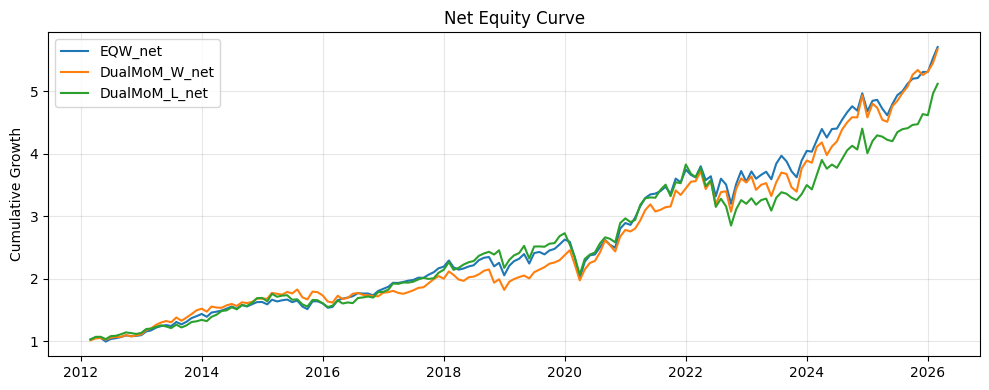

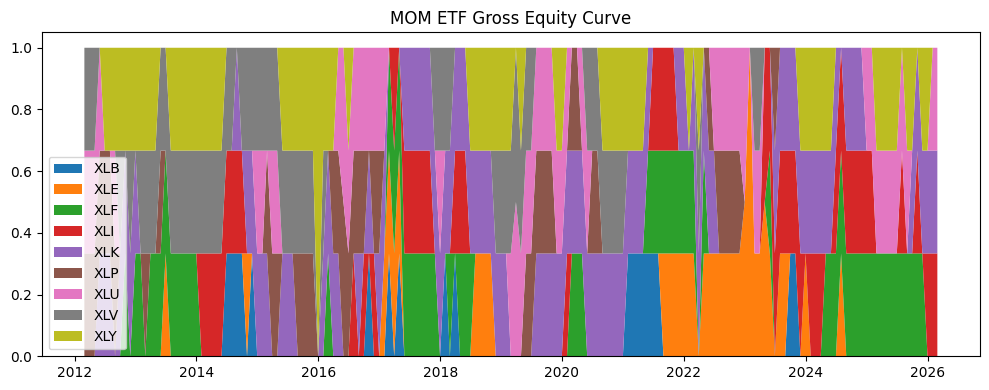

In [61]:
def plot_equity_curve(ret_series: pd.Series, title: str):
    ret_series = ret_series.dropna()
    eq = (1 + ret_series.dropna()).cumprod()
    fig, ax = plt.subplots(figsize=(10, 4))
    for item in eq.columns:
        ax.plot(eq[item], label=item)
    ax.set_title(title)
    ax.set_ylabel('Cumulative Growth')
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()

def plot_weights(weights, title):
    fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
    ax.set_title(title)
    ax.stackplot(weights.index, weights.T, labels=weights.columns)
    ax.legend()
    plt.show()

plot_equity_curve(strategy_returns, 'Net Equity Curve')
plot_weights(mom_w.weights, 'MOM ETF Gross Equity Curve')